In [40]:
import matplotlib.pyplot as plt
import numpy as np

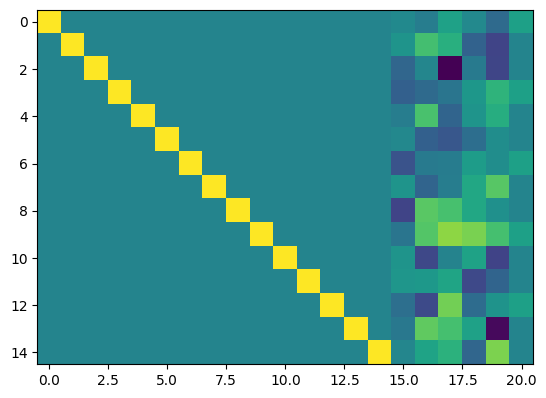

In [41]:
rng = np.random.default_rng(0)
Nf, Nd = 5, 3  # 5 fingers, 3 channels/finger
N = Nf * Nd  # N channels
T = 20  # trial duration
d = 5  # simulated dimensionality (including flexor bias)

w_f, w_p, w_b = .8, .6, .1

# first we have single finger "synergies"
single_finger = np.eye(N)
single_finger /= np.linalg.norm(single_finger)

# then some additional patterns
add_patterns = rng.standard_normal((N, d))
add_patterns /= np.linalg.norm(add_patterns)

# then the flexor bias
flexCh = np.arange(0, N, Nd, dtype=int)
flexBias = np.zeros(N)
flexBias[flexCh] = 1
flexBias /= np.linalg.norm(flexBias)

A = np.c_[w_f * single_finger, w_p * add_patterns, w_b * flexBias]

plt.imshow(A)
plt.show()

In [42]:
# set strength of enslaving
bias_strength = .1
flexBias = np.outer(flexBias, flexBias.T)
coupling = .1
C = np.full((N, N), coupling, dtype=float)
C += 0.02 * rng.standard_normal((N, N))
C += bias_strength * flexBias
np.fill_diagonal(C, 1.0)

# Create a force profile
t = np.linspace(0, 1, T)
profile = np.sin(np.pi * t) ** 2

I = np.eye(N)
B_f = I.reshape(Nf, Nd, N)
B_p = rng.standard_normal((Nf, Nd, d))
B_b = np.c_[np.ones((Nf, 1)), np.zeros((Nf, 2))]
B = np.c_[B_f, B_p, B_b[:, :, None]]

In [43]:
# example trials
n_trials = 100
F = np.zeros((n_trials, T, N), dtype=float)
fingers = np.zeros(n_trials, dtype=int)
dirs = np.zeros((n_trials, 3), dtype=float)
for tr in range(n_trials):
    f = rng.integers(0, Nf)          # which finger is instructed
    v = np.array([-1, 0, 0], dtype=float)       # movement direction in 3D
    v /= (np.linalg.norm(v) + 1e-12)
    amp = 1 + .2 * rng.standard_normal() # movement amplitude
    z_vec = v[0] * B[f, 0] + v[1] * B[f, 1] + v[2] * B[f, 2] # (d,)
    Z = (amp * profile)[:, None] * z_vec[None, :] # (T, d)
    X = Z @ A.T
    noise=.0
    X += noise * rng.standard_normal(X.shape)
    Ft = X #@ C.T
    F[tr] = Ft
    fingers[tr] = f

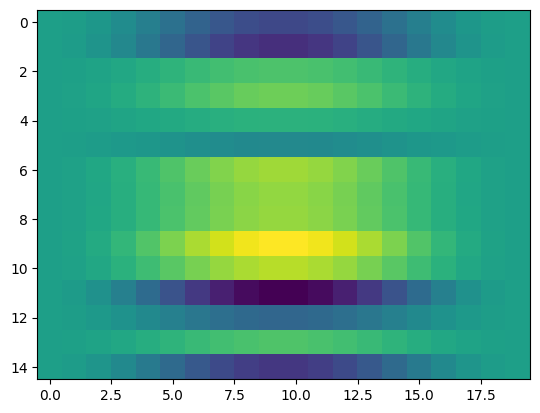

In [44]:
plt.imshow(Ft.T)

In [45]:
F_thumb = F[fingers == 0, 10].mean(axis=0)
F_index = F[fingers == 1, 10].mean(axis=0)
F_middle = F[fingers == 2, 10].mean(axis=0)
F_ring = F[fingers == 3, 10].mean(axis=0)
F_pinkie = F[fingers == 4, 10].mean(axis=0)

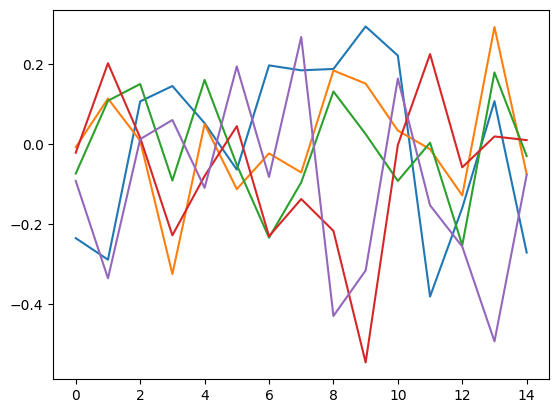

In [46]:
plt.plot(F_thumb)
plt.plot(F_index)
plt.plot(F_middle)
plt.plot(F_ring)
plt.plot(F_pinkie)

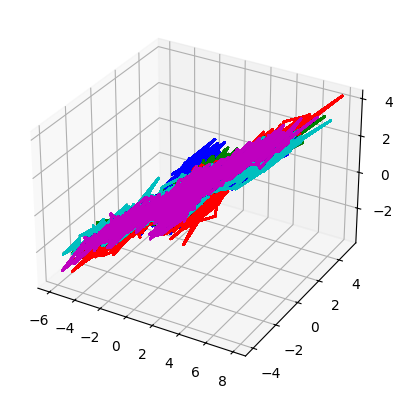

In [22]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
color = ['b', 'g', 'r', 'c', 'm']
for f in range(Nf):
    for tr in range(n_trials):
        ax.plot(F[:, :, f, 0], F[:, :, f, 1], F[:, :, f, 2], color=color[f])

plt.show()